<a href="https://colab.research.google.com/github/HangPhan18/skin_cancer/blob/main/cnn/pre_cont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
import pandas  as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, MaxPool2D, Conv2D, GlobalAveragePooling2D, AveragePooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
cd /content/drive/MyDrive/LuanVan/dataHAM

/content/drive/MyDrive/LuanVan/dataHAM


In [ ]:
file = os.listdir('ham10000_images_part_2')
len(file)

5015

In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

Archive:  skin-cancer-mnist-ham10000.zip
replace HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
skin_df = pd.read_csv('HAM10000_metadata.csv')

# Kiểm tra dữ liệu 

In [ ]:
def basic_DF(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

# Data missing

In [ ]:
def summary_table(df):
  summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
  summary = summary.reset_index()

  summary["Name"] = summary['index']
  summary = summary[['Name', 'dtypes']]
  summary['Missing'] = df.isnull().sum().values
  summary['Uniques'] = skin_df.nunique().values
  
  return summary


In [ ]:
basic_DF(skin_df)


Number of Samples: 10015,
Number of Features: 7,
Duplicated Entries: 0,
Null Entries: 57,
Number of Rows with Null Entries: 57 0.6%


In [ ]:
def countplot(df, x, x_axis_title, y_axys_title, plot_title):
  plt.figure(figsize=(20, 8))
  sns.set(style='ticks', font_scale=1)
  ax = sns.countplot(data = df, x = x, order=df[x].value_counts().index, palette='Blues_d')
  sns.despine(top=True, right = True, left = True, bottom=False)
  plt.xticks(rotation=0, fontsize=12)
  ax.set_xlabel(x_axis_title, font_size=14, weight = 'bold')
  ax_set_ylabel(y_axys_title, font_size = 14, weight = 'bold')
  plt.title(plot_title, fontsize = 16, weight ='bold')



 Lesion Dictionary

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevae',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
img_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('/content/drive/MyDrive/LuanVan/dataHAM/', '*', '*.jpg'))}

Tạo các cột đường dẫn hình ảnh, loại thương tổn và mã phân loại thương tổn

In [ ]:
skin_df['path'] = skin_df['image_id'].map(img_path_dict.get)

In [ ]:
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)


In [ ]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.head(100)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
95,HAM_0000746,ISIC_0027023,bkl,histo,60.0,male,face,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
96,HAM_0001473,ISIC_0029022,bkl,histo,70.0,male,face,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
97,HAM_0003007,ISIC_0025388,bkl,histo,40.0,female,abdomen,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2
98,HAM_0003007,ISIC_0028080,bkl,histo,40.0,female,abdomen,/content/drive/MyDrive/LuanVan/dataHAM/ham1000...,Benign keratosis-like lesions,2


In [ ]:
img = skin_df.sample(n= 500, replace=False, random_state = 1)
img['image'] = img['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
img['image']

4141    [[[244, 162, 176], [246, 169, 184], [247, 181,...
3625    [[[233, 152, 158], [235, 157, 165], [236, 157,...
8279    [[[255, 210, 255], [255, 210, 255], [254, 210,...
3903    [[[236, 161, 172], [237, 162, 173], [239, 162,...
2573    [[[62, 44, 44], [86, 64, 62], [113, 88, 88], [...
                              ...                        
5844    [[[208, 132, 145], [202, 123, 136], [213, 136,...
9039    [[[139, 113, 123], [140, 114, 124], [139, 113,...
1814    [[[189, 186, 200], [190, 183, 195], [189, 181,...
961     [[[184, 170, 186], [187, 173, 190], [190, 177,...
5216    [[[217, 112, 119], [218, 112, 121], [219, 111,...
Name: image, Length: 500, dtype: object

In [ ]:
n_samples = 3

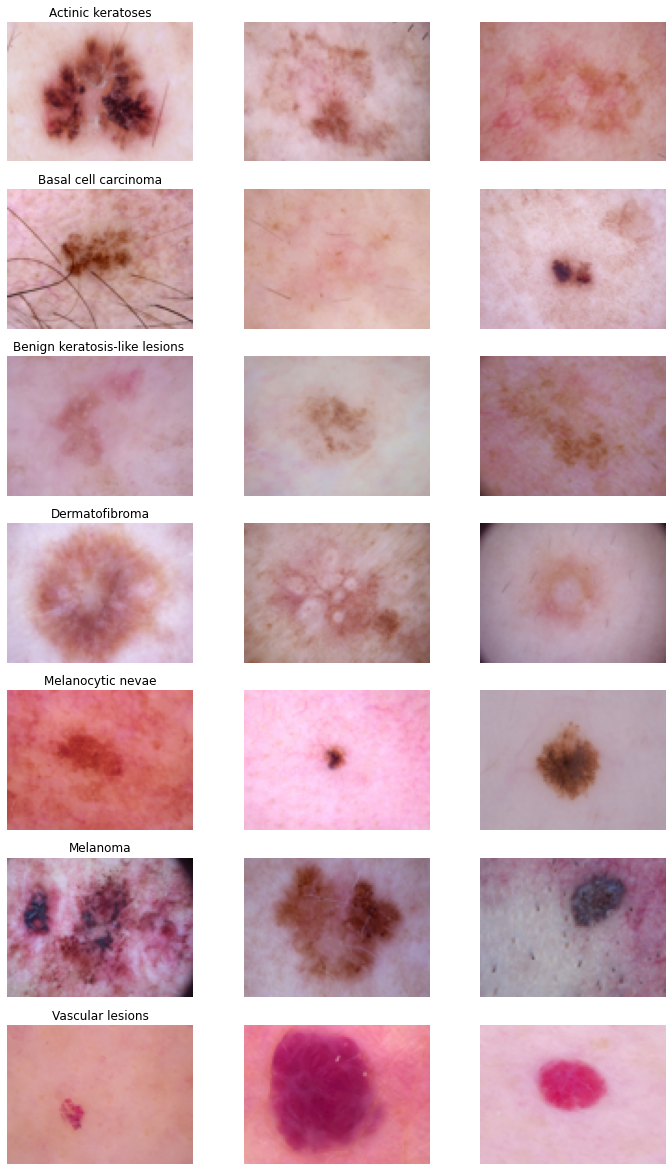

In [ ]:
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, img.sort_values(['cell_type']).groupby('cell_type')):
  n_axs[0].set_title(type_name)
  for c_axs, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
    c_axs.imshow(c_row['image'])
    c_axs.axis('off')

In [ ]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,path,object,0,10015
8,cell_type,object,0,7
9,cell_type_idx,int8,0,7


In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))


In [ ]:
features= skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']


In [ ]:
target

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    5
Name: cell_type_idx, Length: 10015, dtype: int8

Chuẩn hóa dữ liệu đầu vào

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2, random_state=123)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())


In [ ]:
print(x_train)
print(x_test)

[[[[245 169 184]
   [246 167 179]
   [242 165 173]
   ...
   [248 182 193]
   [248 183 192]
   [248 183 191]]

  [[244 166 179]
   [244 165 172]
   [241 161 164]
   ...
   [248 180 191]
   [248 182 191]
   [248 181 190]]

  [[243 164 176]
   [240 161 169]
   [238 159 165]
   ...
   [248 178 190]
   [248 180 190]
   [248 178 188]]

  ...

  [[231 163 162]
   [235 165 165]
   [234 166 165]
   ...
   [239 162 167]
   [236 163 167]
   [237 165 169]]

  [[234 165 167]
   [236 169 169]
   [235 168 168]
   ...
   [236 161 165]
   [235 159 163]
   [237 163 168]]

  [[235 168 169]
   [238 172 171]
   [238 171 172]
   ...
   [234 160 162]
   [237 161 165]
   [235 162 166]]]


 [[[158 141 157]
   [158 142 159]
   [160 145 164]
   ...
   [157 144 148]
   [155 143 148]
   [155 143 148]]

  [[158 140 156]
   [158 140 157]
   [158 141 157]
   ...
   [157 145 149]
   [156 144 149]
   [155 144 150]]

  [[159 140 154]
   [159 139 156]
   [159 140 157]
   ...
   [158 145 150]
   [156 146 148]
   [155 144

In [ ]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)


In [ ]:
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

*One hot coding các nhãn target

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes=7)

Chia dữ liệu đào tạo thành tập train và tập validate

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state=123)

Định hình hình ảnh thành 3 kên RGB với kích thước 75x100

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
x_train.shape

(7210, 75, 100, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


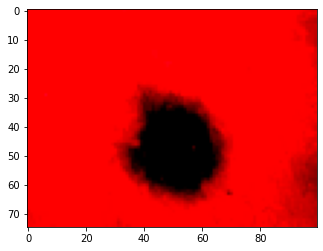

In [ ]:
plt.imshow(x_train[1], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


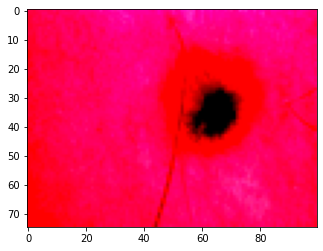

In [ ]:
plt.imshow(x_train[500])


Thông số mô hình

In [ ]:
input_shape = (75, 100, 3)
num_classes = 7

In [ ]:
optimizer = Adam(learning_rate= 0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False, decay = 0.0)

epochs = 60
batch_size = 20

Callbacks

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, verbose = 0, factor = 0.5, min_lr= 0.00001)
early_stopping_monitor = EarlyStopping(patience = 20, monitor = 'val_accuracy')


Tăng cường dữ liệu (Data Augmentation)

In [ ]:
dataaugment = ImageDataGenerator(
    featurewise_center = False, #Đặt trung bình đầu vào bằng 0 trên tập dữ liệu
    samplewise_center = False, #Đặt giá trung bình của mỗi mẫu bằng 0
    featurewise_std_normalization = False, #Chia đầu vào 
    samplewise_std_normalization=False,
    zca_whitening = False,
    rotation_range = 90,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 10
)

In [ ]:
print(x_train.shape)

print(x_validate.shape)

print(x_test.shape)

(7210, 75, 100, 3)
(802, 75, 100, 3)
(2003, 75, 100, 3)


In [ ]:
dataaugment.fit(x_train)


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size =(3, 3), activation ='relu', padding = 'Same', input_shape = input_shape))
model.add(BatchNormalization())

##################################
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))
##################################
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))
##################################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation = 'softmax'))

#y_pred, accuracy_t, accuracy_v, accuracy = history(model)

#print("Training: accuracy = %f" %(accuracy_t))
#print("Validate: accuracy = %f" %(accuracy_v))
#print("Test: accuracy = %f" %(accuracy))




In [ ]:
 model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#def history(model):
    #model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
predictions = model.predict(x_test)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
    #return (predictions,accuracy_t,accuracy_v,accuracy)

Epoch 1/60
360/360 - 23s - loss: 0.5583 - accuracy: 0.7908 - val_loss: 0.5637 - val_accuracy: 0.8005 - lr: 1.0000e-05 - 23s/epoch - 64ms/step
Epoch 2/60
360/360 - 22s - loss: 0.5548 - accuracy: 0.7946 - val_loss: 0.5627 - val_accuracy: 0.7980 - lr: 1.0000e-05 - 22s/epoch - 62ms/step
Epoch 3/60
360/360 - 22s - loss: 0.5627 - accuracy: 0.7840 - val_loss: 0.5657 - val_accuracy: 0.8005 - lr: 1.0000e-05 - 22s/epoch - 62ms/step
Epoch 4/60
360/360 - 22s - loss: 0.5564 - accuracy: 0.7942 - val_loss: 0.5630 - val_accuracy: 0.7968 - lr: 1.0000e-05 - 22s/epoch - 62ms/step
Epoch 5/60
360/360 - 23s - loss: 0.5574 - accuracy: 0.7929 - val_loss: 0.5656 - val_accuracy: 0.7993 - lr: 1.0000e-05 - 23s/epoch - 63ms/step
Epoch 6/60
360/360 - 22s - loss: 0.5535 - accuracy: 0.7982 - val_loss: 0.5650 - val_accuracy: 0.8017 - lr: 1.0000e-05 - 22s/epoch - 62ms/step
Epoch 7/60
360/360 - 22s - loss: 0.5682 - accuracy: 0.7892 - val_loss: 0.5638 - val_accuracy: 0.7993 - lr: 1.0000e-05 - 22s/epoch - 62ms/step
Epoch 

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
predictions = model.predict(x_test)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)

In [ ]:

print("Training: accuracy = %f" %(accuracy_t))
print("Validate: accuracy = %f" %(accuracy_v))
print("Test: accuracy = %f" %(accuracy))

Training: accuracy = 0.815395
Validate: accuracy = 0.796758
Test: accuracy = 0.768348


In [ ]:
model.save("cnn_v1.h5")


In [ ]:
new_model = keras.models.load_model('cnn_v1.h5')

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 batch_normalization (BatchN  (None, 75, 100, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 100, 64)      256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 37, 50, 64)       0         
 ooling2D)                                                       
                                                        

In [ ]:
loss, acc = new_model.evaluate(x_test, y_test, verbose = 2)
print('Restore model, accuracy: {:5.2f}%'.format(100*acc))

63/63 - 2s - loss: 0.6040 - accuracy: 0.7683 - 2s/epoch - 26ms/step
Restore model, accuracy: 76.83%


In [ ]:
values_dict = lesion_type_dict.values()
print(values_dict)

values_list = list(values_dict)
print(values_list[6])


dict_values(['Melanocytic nevae', 'Melanoma', 'Benign keratosis-like lesions ', 'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma'])
Dermatofibroma


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

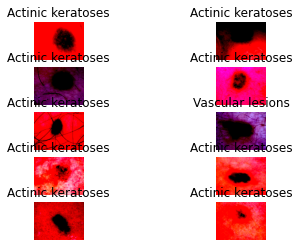

In [ ]:
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(x_test[500+i])
    plt.title(values_list[np.argmax(new_model.predict(x_test[500+i].reshape(-1, 75, 100, 3)))]);
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

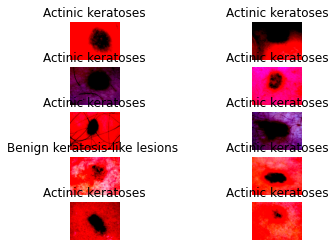

In [ ]:
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(x_test[500+i])
    plt.title(values_list[np.argmax(y_test[500+i])])
    plt.axis('off')

In [ ]:
acc = 0
for i in range(100):
  if values_list[np.argmax(y_test[500+i])] == values_list[np.argmax(new_model.predict(x_test[500+i].reshape(-1, 75, 100, 3)))]:
    acc += 1
print(acc/100)

0.77


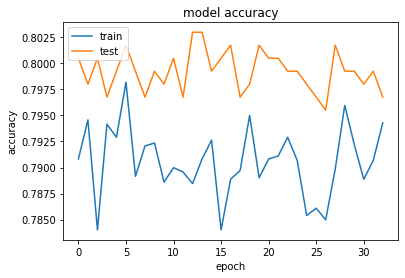

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

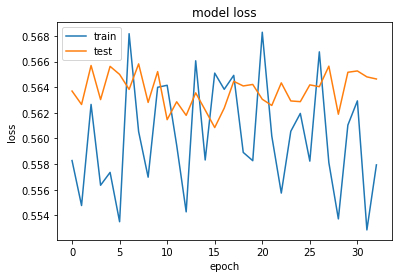

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

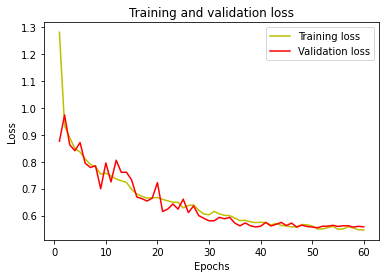

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#ResNet50

In [ ]:
from resnet50 import *

# ResNet50

In [ ]:
base_model = ResNet50(include_top = False, input_shape = (75, 100, 3), pooling ='avg', weights ='imagenet')

ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation ='relu'))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation='softmax'))


for layer in base_model.layers:
  layer.trainable = True
  
ResNet50model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history_resnet50 = ResNet50model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = 60, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

ResNet50_loss, ResNet50_accuracy = ResNet50model.evaluate(x_test, y_test, verbose=0)
predictions = ResNet50model.predict(x_test)
ResNet50_loss_v, ResNet50_accuracy_v = ResNet50model.evaluate(x_validate, y_validate, verbose=0)
ResNet50_loss_t, ResNet50_accuracy_t = ResNet50model.evaluate(x_train, y_train, verbose=0)
#ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)
    
print("ResNet50 Training: accuracy = %f" % (ResNet50_accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (ResNet50_accuracy_v))
print("ResNet50 Test: accuracy = %f" % (ResNet50_accuracy))


Epoch 1/60
360/360 - 70s - loss: 0.9458 - accuracy: 0.6826 - val_loss: 3.3135 - val_accuracy: 0.6621 - lr: 1.0000e-05 - 70s/epoch - 196ms/step
Epoch 2/60
360/360 - 58s - loss: 0.7458 - accuracy: 0.7327 - val_loss: 0.8980 - val_accuracy: 0.7082 - lr: 1.0000e-05 - 58s/epoch - 161ms/step
Epoch 3/60
360/360 - 58s - loss: 0.6875 - accuracy: 0.7541 - val_loss: 0.6133 - val_accuracy: 0.7843 - lr: 1.0000e-05 - 58s/epoch - 161ms/step
Epoch 4/60
360/360 - 58s - loss: 0.6357 - accuracy: 0.7725 - val_loss: 0.5901 - val_accuracy: 0.7830 - lr: 1.0000e-05 - 58s/epoch - 162ms/step
Epoch 5/60
360/360 - 58s - loss: 0.6067 - accuracy: 0.7805 - val_loss: 0.5783 - val_accuracy: 0.7968 - lr: 1.0000e-05 - 58s/epoch - 161ms/step
Epoch 6/60
360/360 - 58s - loss: 0.5754 - accuracy: 0.7848 - val_loss: 0.5580 - val_accuracy: 0.8055 - lr: 1.0000e-05 - 58s/epoch - 161ms/step
Epoch 7/60
360/360 - 58s - loss: 0.5590 - accuracy: 0.7968 - val_loss: 0.5482 - val_accuracy: 0.8092 - lr: 1.0000e-05 - 58s/epoch - 161ms/step

In [ ]:
ResNet50model.save('modelResNet50_v1.h5')


In [ ]:
new_modelResnet50 = keras.models.load_model('modelResNet50_v1.h5')

new_modelResnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 23,850,887
Trainable params: 23,797,767
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
loss, acc = new_modelResnet50.evaluate(x_test, y_test, verbose = 2)
print('Restore model, accuracy: {:5.2f}%'.format(100*acc))

63/63 - 6s - loss: 0.7410 - accuracy: 0.8228 - 6s/epoch - 91ms/step
Restore model, accuracy: 82.28%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

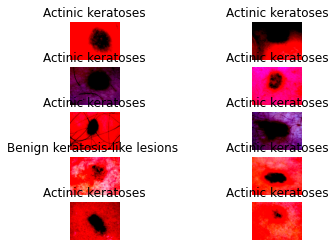

In [ ]:
for i in range(10):
    plt.subplot(5, 2, i+1);
    plt.imshow(x_test[500+i]);
    plt.title(values_list[np.argmax(new_modelResnet50.predict(x_test[500+i].reshape(-1, 75, 100, 3)))]);
    plt.axis('off');


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

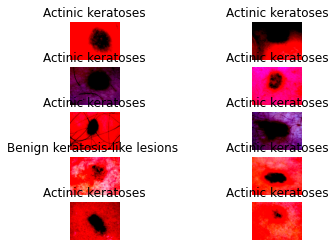

In [ ]:
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(x_test[500+i])
    plt.title(values_list[np.argmax(y_test[500+i])]);
    plt.axis('off')

In [ ]:
acc = 0
for i in range(100):
  if values_list[np.argmax(y_test[500+i])] == values_list[np.argmax(new_modelResnet50.predict(x_test[500+i].reshape(-1, 75, 100, 3)))]:
    acc += 1
print(acc/100)

0.81


In [ ]:
training_shape = (75, 100, 3)
base_model = Xception(include_top = False, weights = 'imagenet', input_shape = training_shape)

In [ ]:
XCeption = base_model.output
XCeption = Flatten()(XCeption)
XCeption = BatchNormalization()(XCeption)
XCeption = Dense(128, activation = 'relu')(XCeption)
XCeption = Dropout(0.2) (XCeption)

XCeption = BatchNormalization()(XCeption)
XCeption = Dense(num_classes, activation = 'softmax')(XCeption)
XCeption = Model(inputs = base_model.input, outputs = XCeptionoutput )

for layer in base_model.layers:
  layer.trainable = True

#XCeption_pred, XCeptionaccuracy_t, XCeptionaccuracy_v, XCeptionaccuracy = history(XCeption)
XCeption.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history_resnet50 = XCeption.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = 60, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

#print("XCeption Training: accuracy = %f" % (XCeptionaccuracy_t))
#print("XCeption Validation: accuracy = %f" % (XCeptionaccuracy_v))
#print("XCeption Test: accuracy = %f" % (XCeptionaccuracy))


XCeption_loss, XCeption_accuracy = XCeption.evaluate(x_test, y_test, verbose=0)
predictions = XCeption.predict(x_test)
XCeption_loss_v, XCeption_accuracy_v = XCeption.evaluate(x_validate, y_validate, verbose=0)
XCeption_loss_t, XCeption_accuracy_t = XCeption.evaluate(x_train, y_train, verbose=0)
#ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)
    
print("ResNet50 Training: accuracy = %f" % (XCeption_accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (XCeption_accuracy_v))
print("ResNet50 Test: accuracy = %f" % (XCeption_accuracy))